<a href="https://colab.research.google.com/github/TuanPham2024/M5W3-Mutilayer-Perceptrons_MLPs/blob/main/M5W3_8_1_Car_miles_per_gallon_Regression_MLP_ReLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://drive.google.com/file/d/1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu/view?usp=sharing
!gdown 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 31.5MB/s]


**1. Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

**2. Read dataset**

In [ ]:
# 2. Read dataset
path_dataset = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(path_dataset)
dataset.head(2), "/n......../n" ,dataset.tail(2)

(    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
 0  18.0          8         307.0       130.0  3504.0          12.0   
 1  15.0          8         350.0       165.0  3693.0          11.5   
 
    Model Year  Europe  Japan  USA  
 0          70       0      0    1  
 1          70       0      0    1  ,
 '/n......../n',
       MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
 390  28.0          4         120.0        79.0  2625.0          18.6   
 391  31.0          4         119.0        82.0  2720.0          19.4   
 
      Model Year  Europe  Japan  USA  
 390          82       0      0    1  
 391          82       0      0    1  )

## **3. Preprocessing data**

### **3.1. X, y split**

In [ ]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

### **3.2. Train/val/test split**

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [ ]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 273
Number of val samples: 79
Number of test samples: 40


**3.3. Data Normalization**

In [ ]:
# pass

## **4. Create PyTorch DataLoader**

In [ ]:
# 6. Create Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # features
        self.y = y  # target
        # self.X = torch.from_numpy(self.X).float().to(device)
        # self.y = torch.from_numpy(self.y).float().to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## **5. Build MLP network**

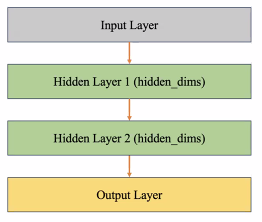

In [ ]:
# 8. Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()

        self.linear1 = nn.Linear(input_dims, hidden_dims)    # Lớp linear 1: input_dims -> hidden_dims

        self.linear2 = nn.Linear(hidden_dims, hidden_dims)   # Lớp linear 2: hidden_dims -> hidden_dims

        self.output = nn.Linear(hidden_dims, output_dims)    # Lớp output: hidden_dims -> output_dims (1)

    def forward(self, x):
        x = self.linear1(x)  # Forward pass qua các lớp với ReLU activation
        x = F.relu(x)        # ReLU activation
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

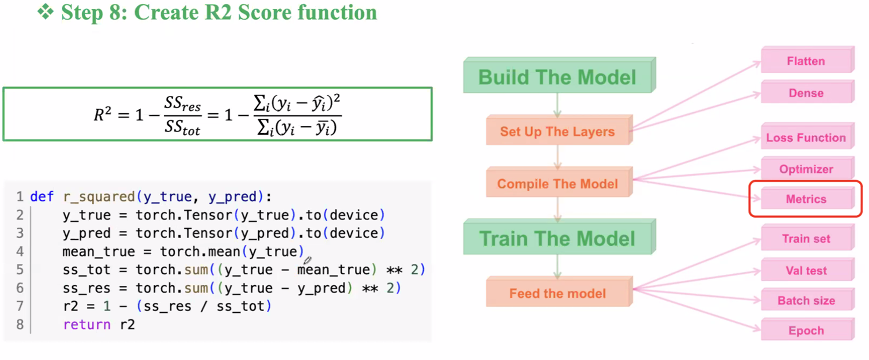

In [ ]:
# 11. R2 score function
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

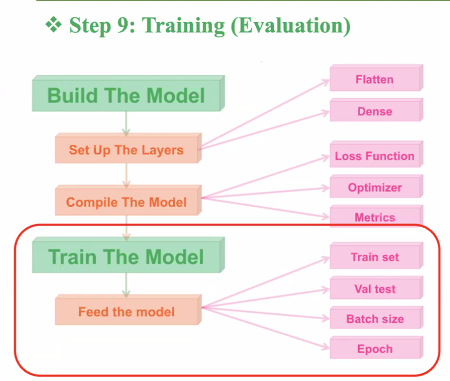

In [ ]:
# 5. Normalize features
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 7. Create DataLoaders
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
val_loader = DataLoader(val_dataset,
                       batch_size=batch_size,
                       shuffle=False)

# 9. Initialize model
input_dims = X_train.shape[1]  # Number of features
output_dims = 1  # Regression task
hidden_dims = 64  # Can be tuned
model = MLP(input_dims=input_dims,
           hidden_dims=hidden_dims,
           output_dims=output_dims).to(device)

# 10. Define loss and optimizer
lr = 1e-2  # Learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# 12. Training loop
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    # Training phase
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_samples)

        # Store predictions
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()

        # Backward pass
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_target = []
    val_predict = []

    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()

            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


<ipython-input-24-a7a5bb642e08>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-24-a7a5bb642e08>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.float32)
<ipython-input-24-a7a5bb642e08>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)



EPOCH 1:	Training loss: 486.537	Validation loss: 361.686

EPOCH 2:	Training loss: 149.210	Validation loss: 29.443

EPOCH 3:	Training loss: 155.752	Validation loss: 158.356

EPOCH 4:	Training loss: 66.456	Validation loss: 67.724

EPOCH 5:	Training loss: 29.525	Validation loss: 9.188

EPOCH 6:	Training loss: 21.752	Validation loss: 12.036

EPOCH 7:	Training loss: 9.816	Validation loss: 7.763

EPOCH 8:	Training loss: 8.897	Validation loss: 6.936

EPOCH 9:	Training loss: 18.113	Validation loss: 33.133

EPOCH 10:	Training loss: 15.364	Validation loss: 7.087

EPOCH 11:	Training loss: 8.778	Validation loss: 10.168

EPOCH 12:	Training loss: 7.407	Validation loss: 6.605

EPOCH 13:	Training loss: 7.967	Validation loss: 9.425

EPOCH 14:	Training loss: 7.741	Validation loss: 7.615

EPOCH 15:	Training loss: 7.970	Validation loss: 12.080

EPOCH 16:	Training loss: 10.779	Validation loss: 5.528

EPOCH 17:	Training loss: 10.940	Validation loss: 16.115

EPOCH 18:	Training loss: 9.979	Validation loss: 6

Evaluation on test set:
R2: 0.8161462545394897


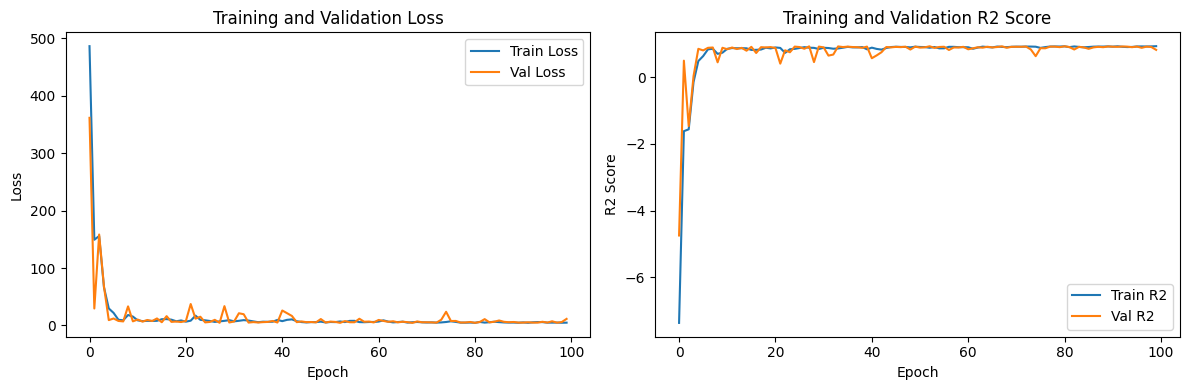

In [ ]:
# 13. Evaluate on test set
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'R2: {test_set_r2}')

# 14. Visualize training results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_r2, label='Train R2')
plt.plot(val_r2, label='Val R2')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()
plt.title('Training and Validation R2 Score')

plt.tight_layout()
plt.show()